In [1]:
import os

os.environ['PYTHONHASHSEED']=str(0)

In [2]:
import random
import keras.utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
import re

In [3]:
random.seed(10)
np.random.seed(10)
keras.utils.set_random_seed(10)


data = pd.read_csv('stock_data.csv')

def remove_links(text):
    tokens = word_tokenize(text)
    filter = [token for token in tokens if "http" not in token]

    return ' '.join(filter)


data['Text'] = data['Text'].apply(lambda x: x.lower())
data['Text'] = data['Text'].apply(remove_links)
data['Text'] = data['Text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data)

                                                   Text  Sentiment
0     kickers on my watchlist xide tit soq pnk cpw b...          1
1     user  aap movie  55  return for the feageed in...          1
2     user i d be afraid to short amzn  they are loo...          1
3                                        mnta over 1200          1
4                                          oi over 2137          1
...                                                 ...        ...
5786  industry body cii said  discoms are likely to ...         -1
5787   gold prices slip below rs 46000 as  investors...         -1
5788  workers at bajaj auto have agreed to a 10  wag...          1
5789   sharemarket live  sensex off day  s high  up ...          1
5790   sensex   nifty climb off day s highs  still u...          1

[5791 rows x 2 columns]


In [8]:
max_features = 1000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['Text'].values) #Updates internal vocabulary based on tweets
X = tokenizer.texts_to_sequences(data['Text'].values) #Translates words into integers
X = pad_sequences(X) #ensures uniformity in input matrix

sent_col_index = data.columns.get_loc('Sentiment')
for i in range(data.shape[0]):
    data.iloc[i, sent_col_index] = 1 if data.iloc[i,sent_col_index] == 1 else 0 #reconfigured to fit binary_crossentropy

Y = data['Sentiment'].values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.15)

In [9]:

embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid')) #Good for binary-class classification
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 128)           128000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 30, 128)           0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 1)                 197       
                                                                 
Total params: 382997 (1.46 MB)
Trainable params: 382997 (1.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [5]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs=5, validation_split=0.2, batch_size=batch_size)

Epoch 1/5
124/124 [==============================] - 9s 70ms/step - loss: 0.6083 - accuracy: 0.6619 - val_loss: 0.5219 - val_accuracy: 0.7299
Epoch 2/5
124/124 [==============================] - 9s 71ms/step - loss: 0.4573 - accuracy: 0.7772 - val_loss: 0.4850 - val_accuracy: 0.7716
Epoch 3/5
124/124 [==============================] - 9s 72ms/step - loss: 0.3937 - accuracy: 0.8240 - val_loss: 0.4777 - val_accuracy: 0.7685
Epoch 4/5
124/124 [==============================] - 9s 72ms/step - loss: 0.3546 - accuracy: 0.8438 - val_loss: 0.4869 - val_accuracy: 0.7807
Epoch 5/5
124/124 [==============================] - 9s 72ms/step - loss: 0.3077 - accuracy: 0.8603 - val_loss: 0.5953 - val_accuracy: 0.7635


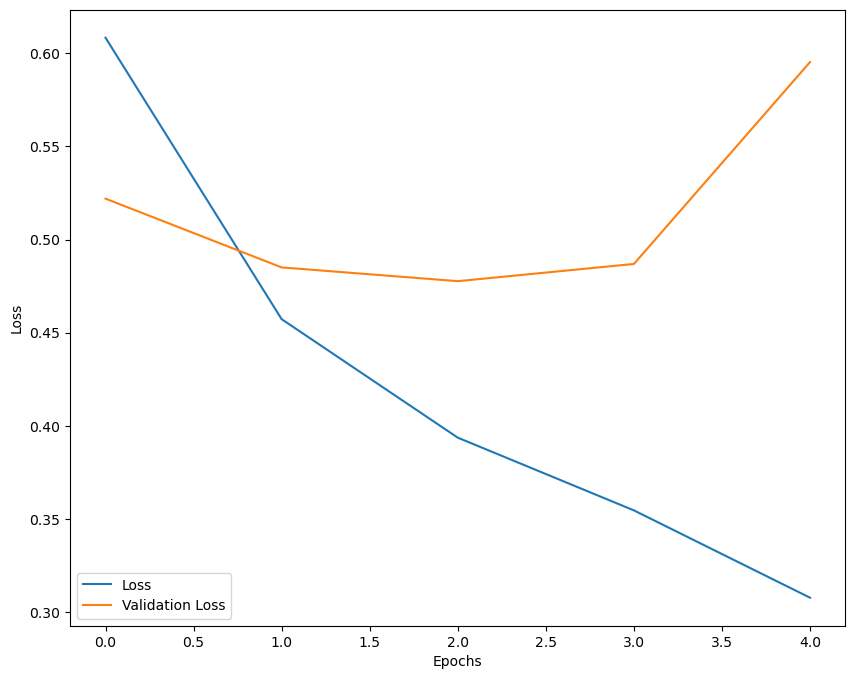

In [6]:

loss_hist = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(10, 8))
plt.plot(loss_hist, label="Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [7]:
score,acc = model.evaluate(X_test, Y_test, batch_size=batch_size)
print(f"Accuracy: {round(acc*100,1)}%")

28/28 [==============================] - 0s 12ms/step - loss: 0.5279 - accuracy: 0.7906
Accuracy: 79.1%
